# Introduction

In this second test notebook we switch from the classic baseline with K-NN to a modern small language model (SLM) for supervised text classification. The SLM model will be supervised finetuned on the AG News Subset training split data and validated on its test split data.

We start from HuggingFaceTB/SmolLM2-135M-Instruct, a compact instruction-tuned Transformer model, and wrap it with AutoModelForSequenceClassification to match the label classes. 

To adapt the model efficiently we apply Parameter Efficient Fine-Tuning (PEFT) with RS-LoRA (r = 64, lora_alpha = 16, lora_dropout = 0.05, targeting all linear layers), train in bfloat16 on GPU, and keep the base weights frozen so only the adapter parameters are updated.

In [12]:
# Import Modules
import evaluate
import numpy as np
import torch
from datasets import load_dataset
from peft import (LoraConfig, 
                  get_peft_model)
from transformers import (AutoTokenizer,
                          DataCollatorWithPadding,
                          TrainingArguments,
                          TrainingArguments, 
                          Trainer,
                          AutoModelForSequenceClassification)

# Plot
import matplotlib.pyplot as plt

## Dataset and Labels

In [2]:
# Load AG News dataset
dataset = load_dataset("ag_news")

# Convert to Pandas DataFrame
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

# Summary
df_train.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [3]:
# Class Labels
label_names = ['World', 'Sports', 'Business', 'Sci/Tech']
df_train['label_name'] = df_train['label'].apply(lambda x: label_names[x])
df_test['label_name'] = df_test['label'].apply(lambda x: label_names[x])

# Dataset Sizes
print("Train size:", len(df_train))
print("Test size:", len(df_test))

Train size: 120000
Test size: 7600


## Tokenizer

In [4]:
# Set Base Model Name
model_name = "HuggingFaceTB/SmolLM2-135M-Instruct"

In [5]:
# Set Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          padding_side = 'right',
                                          device_map = 'auto')
tokenizer.pad_token = tokenizer.eos_token

# Summary
tokenizer

GPT2TokenizerFast(name_or_path='HuggingFaceTB/SmolLM2-135M-Instruct', vocab_size=49152, model_max_length=8192, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|im_start|>', 'eos_token': '<|im_end|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|im_end|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<repo_name>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<reponame>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	5: AddedToken("<file_sep>"

## Preprocess data

In [6]:
# Preprocess Function
def preprocess_function(sample):
    label = sample['label']
    sample = tokenizer(sample['text'], 
                       truncation = False)
    sample['labels'] = label
    return sample

# Class and Id Summary
class2id = {'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}
id2class = {v: k for k, v in class2id.items()}
print(id2class)

# Proces Datasets
train_dataset = dataset["train"].map(preprocess_function).select_columns(['input_ids', 'attention_mask', 'labels'])
test_dataset = dataset["test"].map(preprocess_function).select_columns(['input_ids', 'attention_mask', 'labels'])

# Summary
print(train_dataset)
print(test_dataset)

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 120000
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 7600
})


## Create LoRa Sequence Classification Model

In [7]:
# Create Model
model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                           dtype = torch.bfloat16,
                                                           num_labels = len(class2id.keys())).cuda()
model.use_cache = False

# Summary
model

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM2-135M-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576, padding_idx=2)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((576,), eps=1e-05)
  

In [8]:
# Create LoraConfig
lora_config = LoraConfig(r = 64,
                         lora_alpha = 16,
                         target_modules = 'all-linear',
                         lora_dropout = 0.05,
                         use_rslora = True,
                         bias = "none",
                         task_type = "SEQ_CLS")

# Create Peft Model
model = get_peft_model(model, lora_config)

# LoRA Parameters
model.print_trainable_parameters()

# Summary
model

trainable params: 19,540,224 || all params: 154,057,536 || trainable%: 12.6837


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(49152, 576, padding_idx=2)
        (layers): ModuleList(
          (0-29): 30 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=576, out_features=576, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=576, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=576, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              

# Prepare Evaluation

In [9]:
# Setup Metrics and Evaluation
acc_metric = evaluate.load("accuracy")
prec_metric = evaluate.load("precision")
rec_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Get Predictions
    preds = np.argmax(logits, axis = -1).astype(int)
    labels = labels.astype(int)

    # Final Results
    results = {}
    results.update(acc_metric.compute(predictions = preds, references = labels))
    results.update(prec_metric.compute(predictions = preds, references = labels, average = "weighted"))
    results.update(rec_metric.compute(predictions = preds, references = labels, average = "weighted"))
    results.update(f1_metric.compute(predictions = preds, references = labels, average = "weighted"))
    return results

## Train Model

In [10]:
# Specify Data Collator
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

# Specify TrainingArguments
training_arguments = TrainingArguments(num_train_epochs = 2,
                                       gradient_checkpointing = True,
                                       gradient_checkpointing_kwargs = {'use_reentrant': False},
                                       logging_strategy = 'steps',
                                       logging_steps = 128,
                                       learning_rate = 2.0e-4,
                                       per_device_train_batch_size = 64,
                                       per_device_eval_batch_size = 64,
                                       weight_decay = 0.01,
                                       eval_strategy = 'steps', 
                                       eval_steps = 128,
                                       save_strategy = 'steps',
                                       save_steps = 128,
                                       load_best_model_at_end = True,
                                       report_to = 'none',
                                       gradient_accumulation_steps = 4,
                                       bf16 = True,
                                       warmup_ratio = 0.10, 
                                       metric_for_best_model = 'eval_loss') 

# Create Trainer
trainer = Trainer(model = model, 
                  args = training_arguments,
                  train_dataset = train_dataset,
                  eval_dataset = test_dataset,
                  data_collator = data_collator, 
                  compute_metrics = compute_metrics)

# Perform Model Training
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
128,2.990600,0.238099,0.919605,0.919898,0.919605,0.919345
256,0.865000,0.204656,0.929868,0.930627,0.929868,0.930029
384,0.742300,0.191414,0.933421,0.934134,0.933421,0.933616
512,0.686000,0.178576,0.938421,0.938794,0.938421,0.938514
640,0.557400,0.176569,0.939737,0.939835,0.939737,0.939754
768,0.547900,0.170373,0.942763,0.943113,0.942763,0.942864
896,0.528900,0.167654,0.943816,0.943906,0.943816,0.943801


TrainOutput(global_step=938, training_loss=0.9680488257011625, metrics={'train_runtime': 4091.1426, 'train_samples_per_second': 58.663, 'train_steps_per_second': 0.229, 'total_flos': 2.52224312610816e+16, 'train_loss': 0.9680488257011625, 'epoch': 2.0})

## Plot average performance per Label

Overall accuracy: 94.38%
World: 95.05%
Sports: 98.95%
Business: 90.37%
Sci/Tech: 93.16%


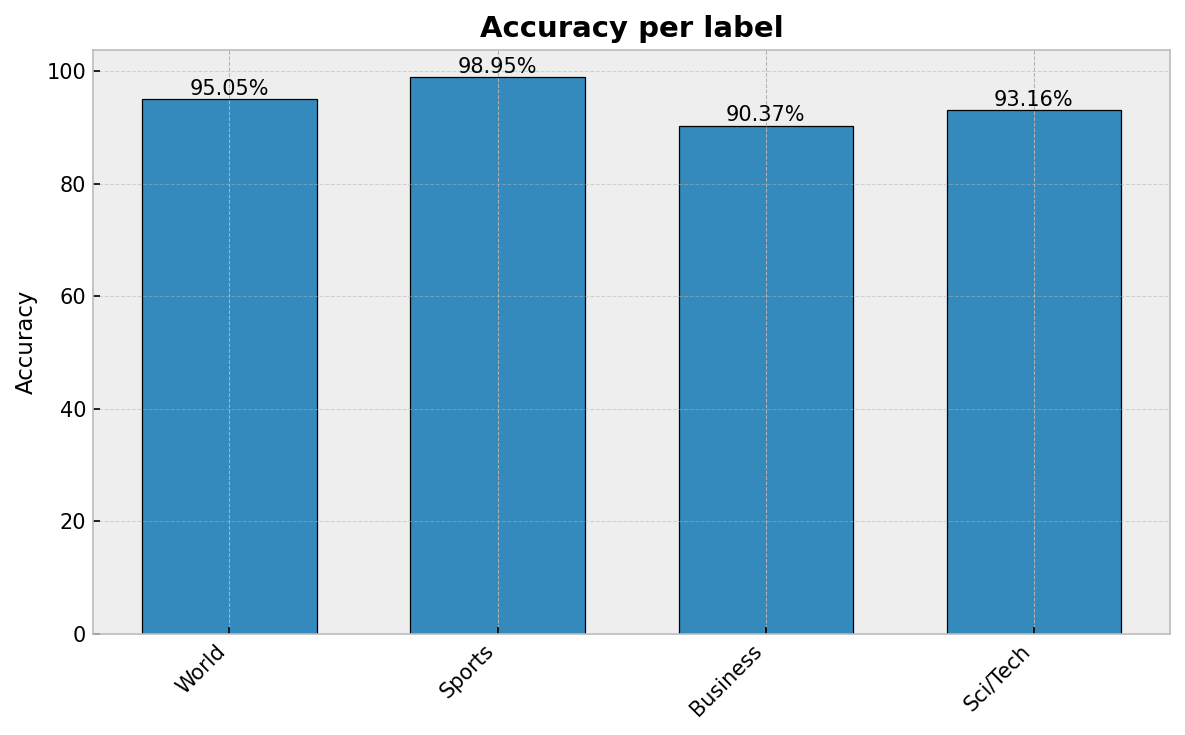

In [11]:
# Predict
pred = trainer.predict(test_dataset)
y = torch.as_tensor(pred.label_ids).view(-1).long()
p = torch.as_tensor(pred.predictions).argmax(-1)

# Accuracies
overall = (p == y).float().mean().item() * 100
acc = (torch.bincount(y, weights=(p == y).float(), minlength = len(label_names)) / torch.bincount(y, minlength = len(label_names))).numpy()
acc *= 100

# Report
print(f"Overall accuracy: {overall:.2f}%")
for name, a in zip(label_names, acc): print(f"{name}: {a:.2f}%")

# Bar chart
plt.style.use("bmh")
plt.figure(figsize = (8, 5), dpi = 150)
bars = plt.bar(range(len(label_names)), acc, width = 0.65, edgecolor = "black", linewidth = 0.6)
plt.xticks(range(len(label_names)), label_names, rotation = 45, ha = "right")
plt.ylabel("Accuracy", fontsize = 11)
plt.title("Accuracy per label", fontsize = 14, weight = "bold")
plt.grid(axis = "y", linestyle = "--", alpha = 0.5)

# Annotate bars
for i, a in enumerate(acc):
    plt.text(i, a + 0.02, f"{a:.2f}%", ha="center", va="bottom", fontsize=10)

# Final Plot
plt.tight_layout()
plt.show()

## Conclusion

The fine-tuned SLM achieves 94.38% overall accuracy on the AG News dataset, establishing a strong baseline.

Per label accuracy ranges from Sports (98.95%) to Business (90.37%) setting a strong performance range for the individual label classes.